In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_error
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import r2_score
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
#Ignore warnings
import warnings
import scipy
import statistics
from datetime import datetime
from platform import python_version
import statsmodels.api as sm
import matplotlib.dates as mdates
print(python_version())
warnings.filterwarnings('ignore')

3.9.7


In [2]:
df = pd.read_csv('Data\\final_burglary_data_city1.csv')
df['year month'] = [datetime.strptime(date, '%Y-%m') for date in df['year month']]
print(sorted(df['city'].unique()))

['Adur', 'Allerdale', 'Amber Valley', 'Arun', 'Ashfield', 'Ashford', 'Aylesbury Vale', 'Babergh', 'Barking and Dagenham', 'Barnet', 'Barnsley', 'Barrow-in-Furness', 'Basildon', 'Basingstoke and Deane', 'Bassetlaw', 'Bath and North East Somerset', 'Bedford', 'Bexley', 'Birmingham', 'Blaby', 'Blackburn with Darwen', 'Blackpool', 'Blaenau Gwent', 'Bolsover', 'Bolton', 'Boston', 'Bournemouth', 'Bracknell Forest', 'Bradford', 'Braintree', 'Breckland', 'Brent', 'Brentwood', 'Bridgend', 'Brighton and Hove', 'Bristol', 'Broadland', 'Bromley', 'Bromsgrove', 'Broxbourne', 'Broxtowe', 'Burnley', 'Bury', 'Caerphilly', 'Calderdale', 'Cambridge', 'Camden', 'Cannock Chase', 'Canterbury', 'Cardiff', 'Carlisle', 'Carmarthenshire', 'Castle Point', 'Central Bedfordshire', 'Ceredigion', 'Charnwood', 'Chelmsford', 'Cheltenham', 'Cherwell', 'Cheshire East', 'Cheshire West and Chester', 'Chesterfield', 'Chichester', 'Chiltern', 'Chorley', 'Christchurch', 'City of London', 'Colchester', 'Conwy', 'Copeland', '

Interesting cities:
Solihull
Adur
Blackpool
Birmingham
Brent
Cambridge
Barnet

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=520.832, Time=0.29 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=554.940, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=529.857, Time=0.14 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=518.841, Time=0.13 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=553.508, Time=0.02 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=542.091, Time=0.05 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=520.837, Time=0.25 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=520.831, Time=0.30 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=529.267, Time=0.16 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=528.912, Time=0.16 sec
 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=520.837, Time=0.17 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=519.696, Time=0.18 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=522.115, Time=0.26 sec
 ARIMA(0,0,1)(0,1,1)[12]             

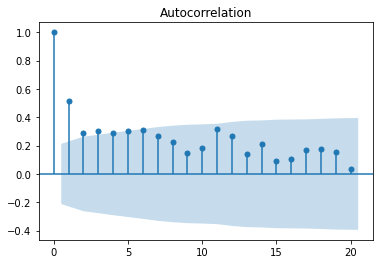

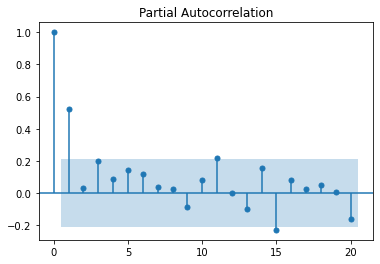

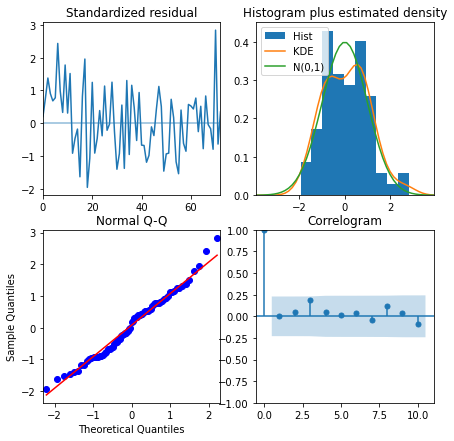

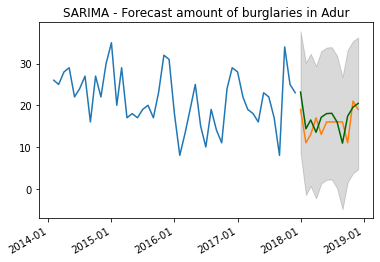

In [3]:
col = 'burglarys city'
n_periods = 12
city = 'Adur'

df_city = df.loc[df['city'] == city]
# Reset index to stop expected value error

df_city_index_reset = df_city.reset_index(drop = True)

#Sort it on year/month to perform ARIMA
df_city_sorted = df_city_index_reset.set_index(df_city_index_reset['year month'])

df_city_train = df_city_sorted['2010-12':'2017-12']
adf = adfuller(df_city_train[col].dropna())

if adf[1] > 0.05:
    df_city_sorted['diff burglarys city'] = df_city_sorted[col].diff()
    col= 'diff burglarys city'
    print('WARNING!\nTime Series is non-stationary, taking the first difference \n')

#Create test partition
df_city_train = df_city_sorted['2010-12':'2017-12']
df_city_test  = df_city_sorted['2018-1':'2019-12']

plot_acf(df_city_train[col].dropna())
plot_pacf(df_city_train[col].dropna())

smodel = auto_arima(df_city_train[col].dropna(), X=None, start_p=1,
                    start_q=1, test='adf',
                    max_p=3, max_q=3, m=12,
                    start_P=0, seasonal=True,
                    d=0, D=1, trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True)
print(smodel.summary())

fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = df_city_test.index[:n_periods]

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

smodel.plot_diagnostics(figsize=(7, 7))
plt.show()
col = 'burglarys city'

if adf[1] > 0.05:
    for i in range(len(df_city_test[:n_periods])):
        if i == 0:
            y = df_city_train[col][-1]
        predicted_upper = y + upper_series[i]
        upper_series[i] = predicted_upper
        predicted_y = y + fitted_series[i]
        fitted_series[i] = predicted_y
        predicted_lower = y + lower_series[i]
        lower_series[i] = predicted_lower
        y=predicted_y

# Plot
plt.plot(df_city_train[col][38:].dropna())
plt.plot(df_city_test[col][:n_periods].dropna())
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index,
                 lower_series,
                 upper_series,
                 color='k', alpha=.15)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()

plt.title(f"SARIMA - Forecast amount of burglaries in {city}")
plt.show()

In [4]:
mae_mean = mean_absolute_error(df_city_test[col][:n_periods].dropna(), [df_city_train[col].mean()]*12)
mae_model = mean_absolute_error(df_city_test[col][:n_periods].dropna(), fitted_series)
diff_mae = (mae_model - mae_mean)/mae_mean
print('MAE avarage amount of burglaries:',mae_mean)
print('MAE SARIMAX model:', mae_model)
print(diff_mae)

MAE avarage amount of burglaries: 9.862745098039218
MAE SARIMAX model: 3.0914686229393182
-0.6865508950896516


In [ ]:
diff_mae_lst = []
mae_lst = []
for city in sorted(df['city'].unique()):
    try:
        #print(city)
        col = 'burglarys city'
        n_periods = 12

        df_city = df.loc[df['city'] == city]
        # Reset index to stop expected value error

        df_city_index_reset = df_city.reset_index(drop = True)

        #Sort it on year/month to perform ARIMA
        df_city_sorted = df_city_index_reset.set_index(df_city_index_reset['year month'])

        df_city_train = df_city_sorted['2010-12':'2017-12']
        adf = adfuller(df_city_train[col].dropna())

        if adf[1] >0.05:
            df_city_sorted['diff burglarys city'] = df_city_sorted[col].diff()
            col= 'diff burglarys city'
            #print('WARNING!\nTime Series is non-stationary, taking the first difference \n')

        #Create test partition
        df_city_train = df_city_sorted['2010-12':'2017-12']
        df_city_test  = df_city_sorted['2018-1':'2019-12']


        smodel = auto_arima(df_city_train[col].dropna(), start_p=1, start_q=1,
                            test='adf',
                            max_p=3, max_q=3, m=12,
                            start_P=0, seasonal=True,
                            d=0, D=1, trace=False,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)


        fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
        index_of_fc = df_city_test.index[:n_periods]

        # make series for plotting purpose
        fitted_series = pd.Series(fitted, index=index_of_fc)
        lower_series = pd.Series(confint[:, 0], index=index_of_fc)
        upper_series = pd.Series(confint[:, 1], index=index_of_fc)

        col = 'burglarys city'
        if adf[1] > 0.05:
            for i in range(len(df_city_test[:n_periods])):
                if i == 0:
                    y = df_city_train[col][-1]
                predicted_upper = y + upper_series[i]
                upper_series[i] = predicted_upper
                predicted_y = y + fitted_series[i]
                fitted_series[i] = predicted_y
                predicted_lower = y + lower_series[i]
                lower_series[i] = predicted_lower
                y=predicted_y

        mae_mean = mean_absolute_error(df_city_test[col][:n_periods].dropna(), [df_city_train[col].mean()]*12)
        mae_model = mean_absolute_error(df_city_test[col][:n_periods].dropna(), fitted_series)
        diff_mae = (mae_model - mae_mean)/mae_mean
        diff_mae_lst.append(diff_mae)
        info = [city, 'mean:',mae_mean,'model:', mae_model, diff_mae]
        print(info, '\n')
        mae_lst.append(info)
        print(statistics.mean(diff_mae_lst), '\n')
    except:
        continue


['Adur', 'mean:', 9.862745098039218, 'model:', 3.0914686229393182, -0.6865508950896516] 

-0.6865508950896516 

['Allerdale', 'mean:', 5.3960784313725485, 'model:', 6.478666942734829, 0.20062505116088783] 

-0.2429629219643819 

['Amber Valley', 'mean:', 15.490196078431373, 'model:', 8.715315030239665, -0.4373657385541482] 

-0.3077638608276373 

['Ashford', 'mean:', 18.590196078431372, 'model:', 18.503298528629923, -0.004674375107977969] 

-0.2319914893977225 

['Basildon', 'mean:', 45.85, 'model:', 51.8859283024145, 0.13164511019442743] 

-0.1592641694792925 



In [ ]:
print(statistics.mean(diff_mae_lst))
mae_lst

In [ ]:
print(statistics.median(diff_mae_lst))

In [ ]:
all_adf = []
for city in sorted(df['city'].unique()):
    df_city = df.loc[df['city'] == city]
    # Reset index to stop expected value error

    df_city_index_reset = df_city.reset_index(drop = True)

    #Sort it on year/month to perform ARIMA
    df_city_sorted = df_city_index_reset.set_index(df_city_index_reset['year month'])

    #Create test partition
    df_city_train = df_city_sorted['2010-12':'2017-12']
    df_city_test  = df_city_sorted['2017-12':'2019-12']
    adf = adfuller(df_city_train[col].dropna())
    all_adf.append([adf[1], city])

In [ ]:
count = 0
for p_value in all_adf:
    if p_value[0] > 0.05:
        print(p_value)
        count+=1
print(f'percentage of cities with a non-stationary time series: {(count/len(all_adf))*100}')

In [10]:
def ad_test(dataset):
    test = adfuller(dataset, autolag = 'AIC')
    print('1. ADF: ',test[0])
    print('2. P-value: ',test[1])
    print('3. Num of Lags: ',test[2])
    print('4. Num of observations for ADF regression and Critical Values Calculation :',test[3])
    print('5. Critical values: ')
    for key, val in test[4].items():
        print('\t',key,':', val)

ad_test(df_city_train['burglarys city'])

1. ADF:  -5.147520136518381
2. P-value:  1.1241206573255471e-05
3. Num of Lags:  0
4. Num of observations for ADF regression and Critical Values Calculation : 84
5. Critical values: 
	 1% : -3.510711795769895
	 5% : -2.8966159448223734
	 10% : -2.5854823866213152
